# Performance Overview

Here, we will example the performance of FNGS as a function of time on several datasets. These investigations were performed on a 4 core machine (4 threads) with a 4.0 GhZ processor.

# BNU1

In [ ]:
%%script false

## disklog.sh
#!/bin/bash -e
# run this in the background with nohup ./disklog.sh > disk.txt &
#
while true; do
    echo "$(du -s $1 | awk '{print $1}')"
    sleep 30
done


##cpulog.sh 
import psutil
import time
import argparse

def cpulog(outfile):
    with open(outfile, 'w') as outf:
        while(True):
            cores = psutil.cpu_percent(percpu=True)
            corestr = ",".join([str(core) for core in cores])
            outf.write(corestr + '\n')
            outf.flush()
            time.sleep(1)  # delay for 1 second

def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('outfile', help='the file to write core usage to.')
    args = parser.parse_args()
    cpulog(args.outfile)

if __name__ == "__main__":
    main()

    
## memlog.sh
#!/bin/bash -e
# run this in the background with nohup ./memlog.sh > mem.txt &
#
while true; do
    echo "$(free -m | grep buffers/cache | awk '{print $3}')"
    sleep 1
done


## runonesub.sh
# A function for generating memory and cpu summaries for fngs pipeline.
#
# Usage: ./generate_statistics.sh /path/to/rest /path/to/anat /path/to/output

rm -rf $3
mkdir $3

./memlog.sh > ${3}/mem.txt &
memkey=$!
python cpulog.py ${3}/cpu.txt &
cpukey=$!
./disklog.sh $3 > ${3}/disk.txt &
diskkey=$!

res=2mm
atlas='/FNGS_server/atlases/atlas/MNI152_T1-${res}.nii.gz'
atlas_brain='/FNGS_server/atlases/atlas/MNI152_T1-${res}_brain.nii.gz'
atlas_mask='/FNGS_server/atlases/mask/MNI152_T1-${res}_brain_mask.nii.gz'
lv_mask='/FNGS_server/atlases/mask/HarvOx_lv_thr25-${res}.nii.gz'
label='/FNGS_server/atlases/label/desikan-${res}.nii.gz'

exec 4<$1
exec 5<$2

fngs_pipeline $1 $2 1 $atlas $atlas_brain $atlas_mask $lv_mask $3 $label --fmt graphml

kill $memkey $cpukey $diskkey

/home/eric/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


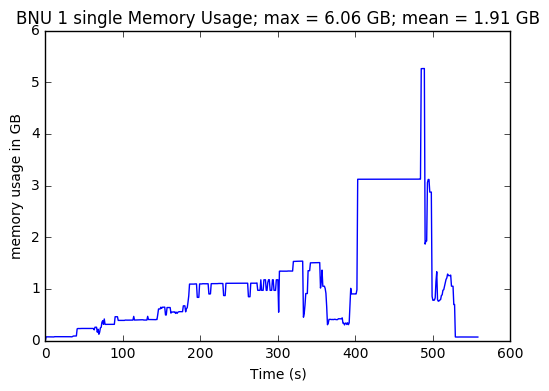

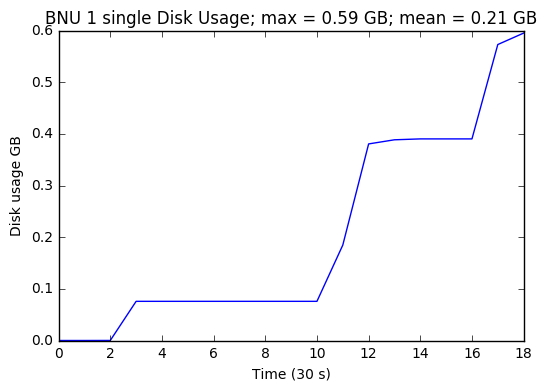

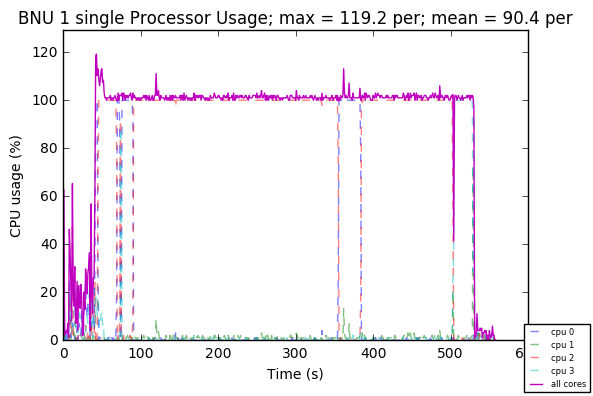

In [1]:
%matplotlib inline
import numpy as np
import re
import matplotlib.pyplot as plt

def memory_function(infile, dataset):
    with open(infile, 'r') as mem:
        lines = mem.readlines()

    testar = np.asarray([line.strip() for line in lines]).astype(float)/1000

    fig=plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(range(0, testar.shape[0]), testar - min(testar))
    ax.set_ylabel('memory usage in GB')
    ax.set_xlabel('Time (s)')
    ax.set_title(dataset + ' Memory Usage; max = %.2f GB; mean = %.2f GB' % (max(testar), np.mean(testar)))
    return fig

def cpu_function(infile, dataset):
    with open(infile, 'r') as cpuf:
        lines = cpuf.readlines()

    testar = [re.split(',',line.strip()) for line in lines][0:-1]
    
    corear = np.zeros((len(testar), len(testar[0])))
    for i in range(0, len(testar)):
        corear[i,:] = np.array([float(cpu) for cpu in testar[i]])
    
    fig=plt.figure()
    ax = fig.add_subplot(111)
    lines = [ax.plot(corear[:,i], '--', label='cpu '+ str(i), 
                     alpha=0.5)[0] for i in range(0, corear.shape[1])]
    
    total = corear.sum(axis=1)
    lines.append(ax.plot(total, label='all cores')[0])
    
    labels = [h.get_label() for h in lines]
    
    fig.legend(handles=lines, labels=labels, loc='lower right', prop={'size':6})
    ax.set_ylabel('CPU usage (%)')
    ax.set_ylim([0, max(total)+10])
    ax.set_xlabel('Time (s)')
    ax.set_title(dataset + ' Processor Usage; max = %.1f per; mean = %.1f per' % (max(total), np.mean(total)))
    return fig

def disk_function(infile, dataset):
    with open(infile, 'r') as disk:
        lines = disk.readlines()

    testar = np.asarray([line.strip() for line in lines]).astype(float)/1000000

    fig=plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(range(0, testar.shape[0]), testar - min(testar))
    ax.set_ylabel('Disk usage GB')
    ax.set_xlabel('Time (30 s)')
    ax.set_title(dataset + ' Disk Usage; max = %.2f GB; mean = %.2f GB' % (max(testar), np.mean(testar)))
    return fig


memfig = memory_function('/data/BNU_sub/BNU_single/mem.txt', 'BNU 1 single')
diskfig = disk_function('/data/BNU_sub/BNU_single/disk.txt', 'BNU 1 single')
cpufig = cpu_function('/data/BNU_sub/BNU_single/cpu.txt', 'BNU 1 single')
memfig.show()
diskfig.show()
cpufig.show()

# HNU Dataset

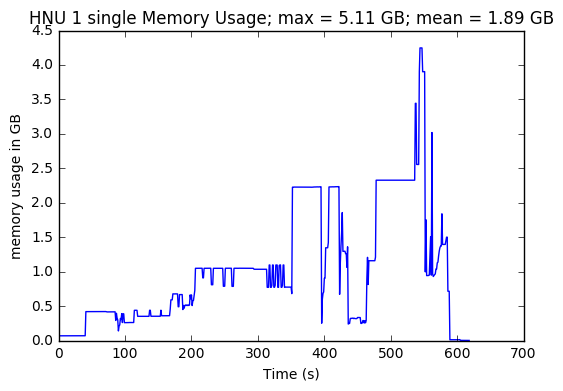

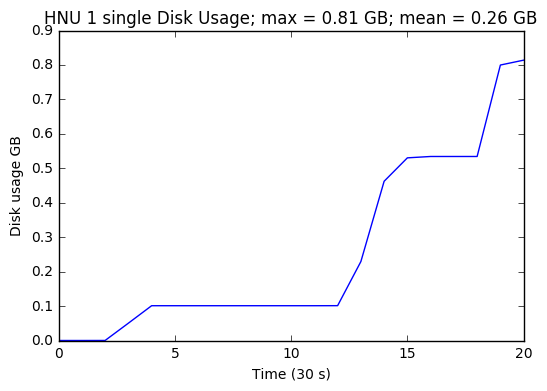

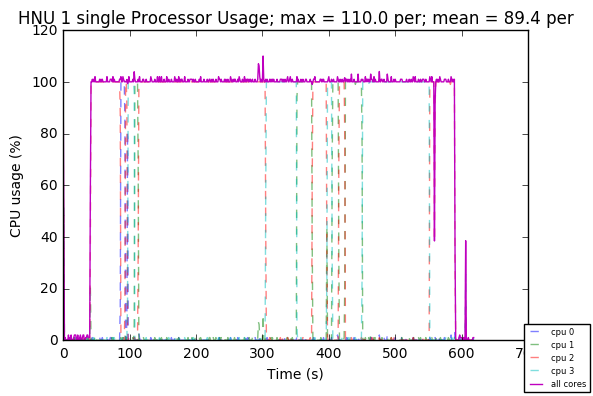

In [2]:
memfig = memory_function('/data/HNU_sub/HNU_single/mem.txt', 'HNU 1 single')
diskfig = disk_function('/data/HNU_sub/HNU_single/disk.txt', 'HNU 1 single')
cpufig = cpu_function('/data/HNU_sub/HNU_single/cpu.txt', 'HNU 1 single')
memfig.show()
diskfig.show()
cpufig.show()

# DC1 Dataset

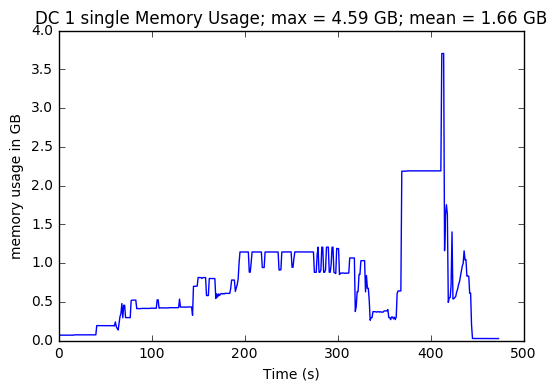

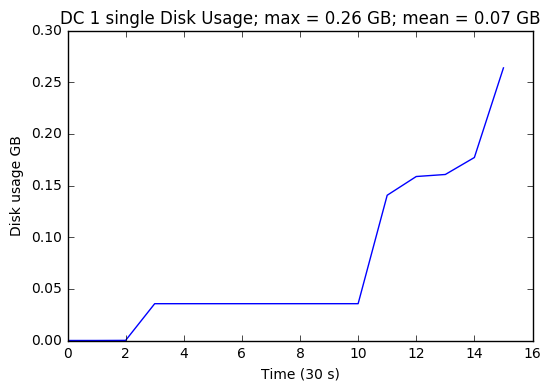

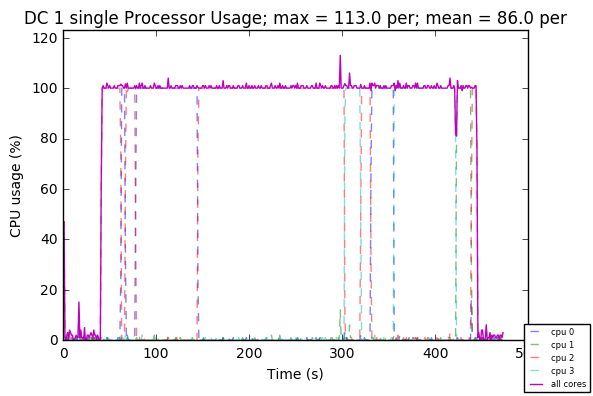

In [9]:
memfig = memory_function('/data/DC_sub/DC_single/mem.txt', 'DC 1 single')
diskfig = disk_function('/data/DC_sub/DC_single/disk.txt', 'DC 1 single')
cpufig = cpu_function('/data/DC_sub/DC_single/cpu.txt', 'DC 1 single')
memfig.show()
diskfig.show()
cpufig.show()

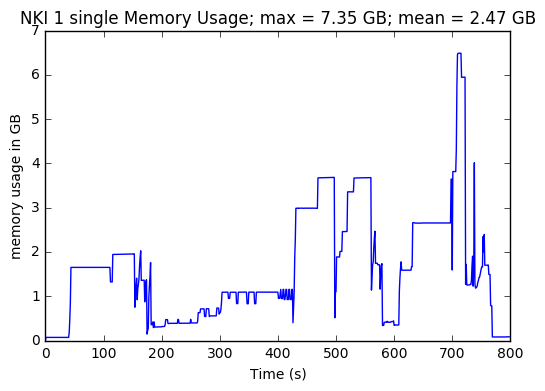

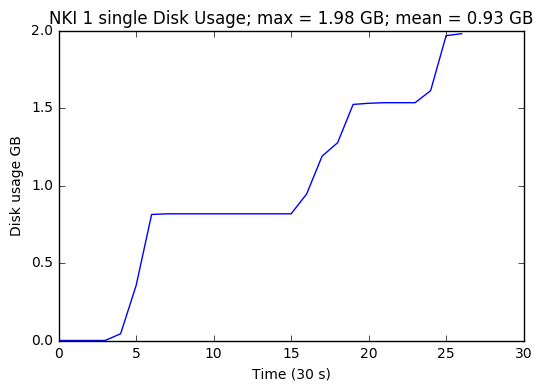

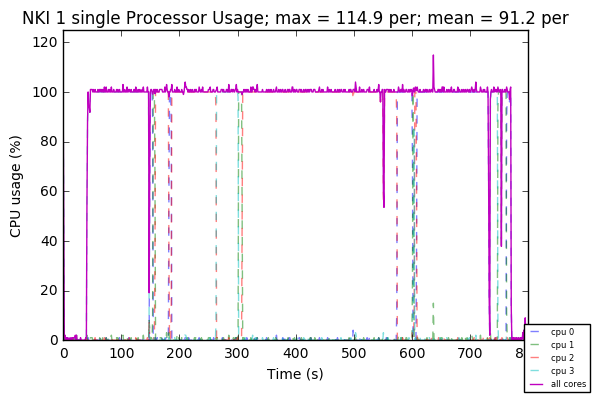

In [4]:
memfig = memory_function('/data/NKI_sub/NKI_single/mem.txt', 'NKI 1 single')
diskfig = disk_function('/data/NKI_sub/NKI_single/disk.txt', 'NKI 1 single')
cpufig = cpu_function('/data/NKI_sub/NKI_single/cpu.txt', 'NKI 1 single')
memfig.show()
diskfig.show()
cpufig.show()

# Multi Subject

Here, we look at two datasets to see how multi subject performance works. Note that statistics are shown for a single subject; ie, the disk usage in particular reflects a single subject's disk usage.

## Two subjects in parallel (run at same time)

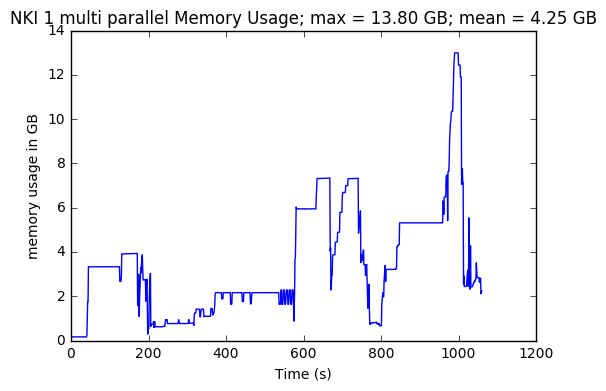

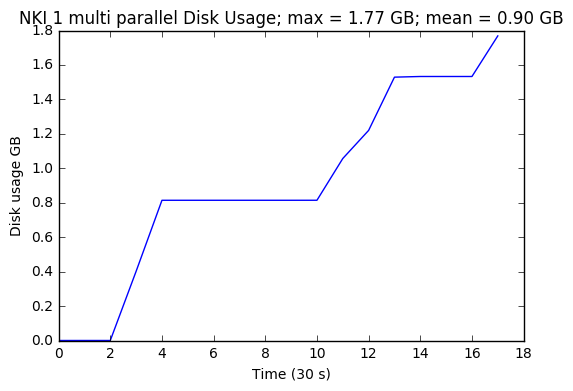

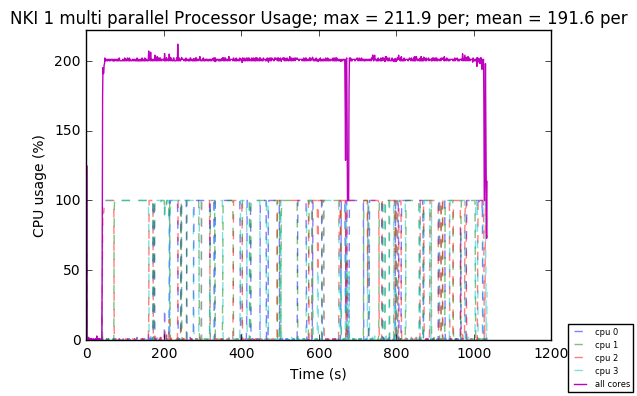

In [5]:
memfig = memory_function('/data/NKI_sub/NKI_parallel2/mem.txt', 'NKI 1 multi parallel')
diskfig = disk_function('/data/NKI_sub/NKI_parallel2/disk.txt', 'NKI 1 multi parallel')
cpufig = cpu_function('/data/NKI_sub/NKI_parallel2/cpu.txt', 'NKI 1 multi parallel')
memfig.show()
diskfig.show()
cpufig.show()

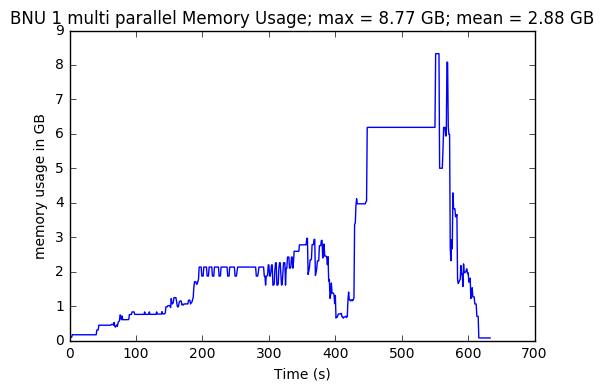

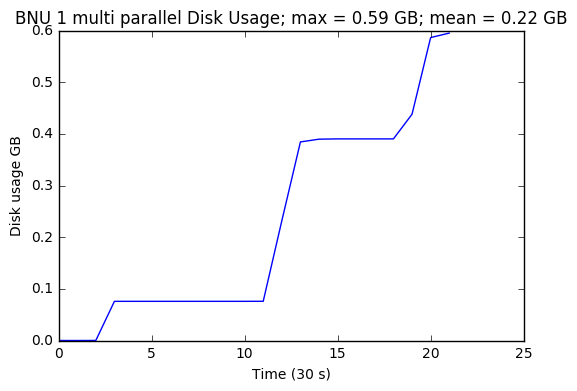

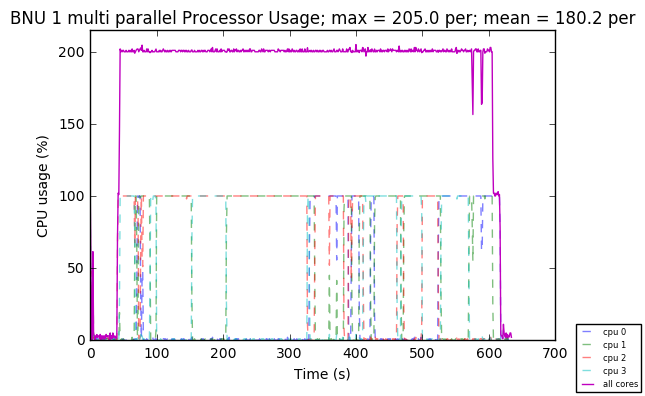

In [6]:
memfig = memory_function('/data/BNU_sub/BNU_parallel1/mem.txt', 'BNU 1 multi parallel')
diskfig = disk_function('/data/BNU_sub/BNU_parallel1/disk.txt', 'BNU 1 multi parallel')
cpufig = cpu_function('/data/BNU_sub/BNU_parallel1/cpu.txt', 'BNU 1 multi parallel')
memfig.show()
diskfig.show()
cpufig.show()

## Two subjects Offset

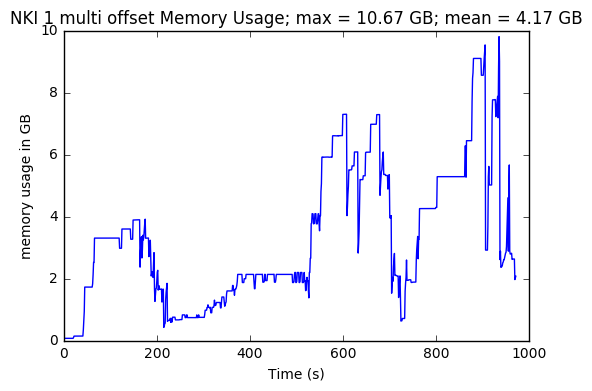

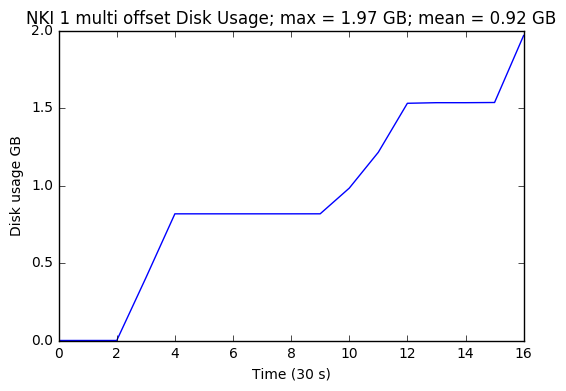

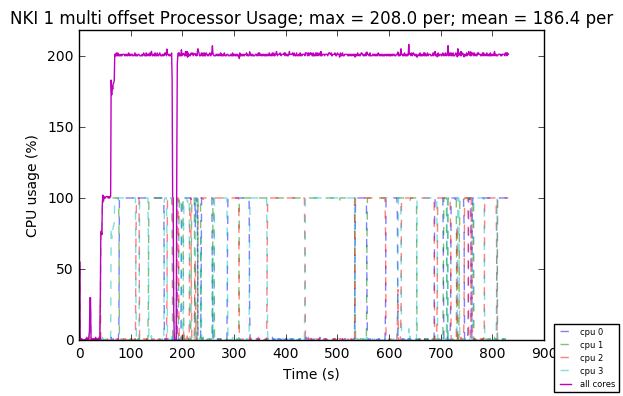

In [7]:
memfig = memory_function('/data/NKI_sub/NKI_parallel3/mem.txt', 'NKI 1 multi offset')
diskfig = disk_function('/data/NKI_sub/NKI_parallel3/disk.txt', 'NKI 1 multi offset')
cpufig = cpu_function('/data/NKI_sub/NKI_parallel3/cpu.txt', 'NKI 1 multi offset')
memfig.show()
diskfig.show()
cpufig.show()

# 1 mm Resolution

I tried repeatedly to get the 1mm trials to work, but it would appear as though 32 gigs of RAM is not sufficient to compute the SVD required by our compcor module.

Solutions:  
1) FFT will be more processor intensive, but should be less memory intensive. This is a step that will be explored next week.  
2) truncated SVD, from sklearn.  